# Iris

Playing with Sklearn's Iris dataset to learn about Pipelines and RandomForest.

In [0]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score,\
                            classification_report, confusion_matrix
from sklearn import preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load and read dataset

Load the iris dataset into a Pandas dataframe

In [0]:
iris = load_iris()
irisdf = pd.DataFrame(data=np.c_[iris['data'], iris['target'], iris['target_names'][iris['target']]],
                      columns=iris['feature_names'] + ['target'] + ['class_name'])
irisdf.shape

(150, 6)

Dataset with 150 samples, each containing 4 features (2 are the target and the class name). Random samples:

In [0]:
irisdf.sample(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,class_name
94,5.6,2.7,4.2,1.3,1,versicolor
11,4.8,3.4,1.6,0.2,0,setosa
9,4.9,3.1,1.5,0.1,0,setosa
48,5.3,3.7,1.5,0.2,0,setosa
82,5.8,2.7,3.9,1.2,1,versicolor


Check our labels:

In [0]:
labelsdf = pd.DataFrame(data=iris['target_names'], columns=['Labels'])
labelsdf

,Labels
0,setosa
1,versicolor
2,virginica


Check our dataset features:

In [0]:
featuresdf = pd.DataFrame(data=iris['feature_names'], columns=['Features'])
featuresdf

,Features
0,sepal length (cm)
1,sepal width (cm)
2,petal length (cm)
3,petal width (cm)


Split our dataset

In [0]:
X_train, X_val, y_train, y_val = train_test_split(iris['data'], iris['target'], test_size=0.33, random_state=46)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((100, 4), (100,), (50, 4), (50,))

### Data preprocessing

We'll use sklearn's StandardScaler to center our dataset in zero, using a Normal distribution, we need to fit the scaler with our train data, and then perform the scale:

In [0]:
scaler = preprocessing.StandardScaler().fit(X_train)


X_train_scaled = scaler.transform(X_train)
X_train_scaled.mean(axis=0), X_train_scaled.std(axis=0)

(array([ 1.30950806e-15, -3.32400774e-15,  1.47763746e-15, -4.44644321e-16]),
 array([1., 1., 1., 1.]))

The means are pretty close to zero, and the standard deviations are all 1.

### Pipeline

RandomForest pipeline with preprocessing:

In [0]:
pipeline = make_pipeline(
    preprocessing.StandardScaler(),
    RandomForestClassifier(n_estimators=100)
)

### Hyperparameters

[Here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [0]:
pipeline.get_params()

{'memory': None,
 'randomforestclassifier': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
                        n_jobs=None, oob_score=False, random_state=None,
                        verbose=0, warm_start=False),
 'randomforestclassifier__bootstrap': True,
 'randomforestclassifier__ccp_alpha': 0.0,
 'randomforestclassifier__class_weight': None,
 'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__max_depth': None,
 'randomforestclassifier__max_features': 'auto',
 'randomforestclassifier__max_leaf_nodes': None,
 'randomforestclassifier__max_samples': None,
 'randomforestclassifier__min_imp

In [0]:
hyperparams = {
    'randomforestclassifier__criterion': ['gini', 'entropy'],
    'randomforestclassifier__max_depth': [None, 100, 80, 50, 40, 20, 10],
    'randomforestclassifier__max_features': ['auto', 'sqrt', 'log2'],
    'randomforestclassifier__class_weight': [None, 'balanced', 'balanced_subsample']
}

### Grid search

In [0]:
search = GridSearchCV(pipeline, hyperparams, cv=10)
search.fit(X_train, y_train)

search.best_params_

{'randomforestclassifier__class_weight': None,
 'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__max_depth': 50,
 'randomforestclassifier__max_features': 'auto'}

### Test

Now that we found the best hyperparameters, we'll predict and check metrics in our testset

In [0]:
final = search

y_pred = final.predict(X_val)

MSE and R2Score

In [0]:
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

mse, r2

(0.1, 0.8515439429928742)

Results are great, low MSE and high score, let's see the classification report:

In [0]:
np.unique(y_pred)

array([0, 1, 2])

In [0]:
# parse labels information
labels = np.unique(iris['target'])
labels_names = iris['target_names']

# get classification report
report = classification_report(y_val,
                               y_pred,
                               labels=labels,
                               target_names=labels_names,
                               zero_division=False)

print(report)

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        19
  versicolor       0.82      0.88      0.85        16
   virginica       0.86      0.80      0.83        15

    accuracy                           0.90        50
   macro avg       0.89      0.89      0.89        50
weighted avg       0.90      0.90      0.90        50



Confusion matrix

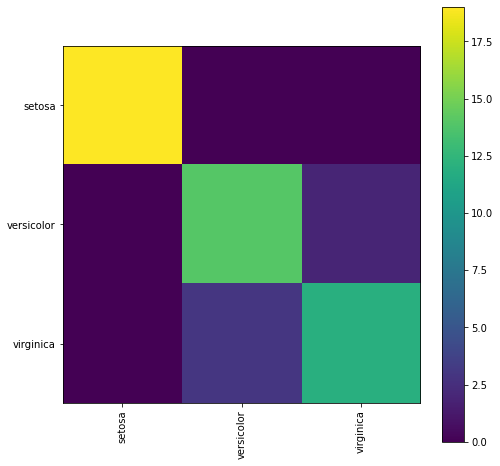

In [0]:
fig, ax = plt.subplots(figsize=(8, 8))
cnf_matrix = confusion_matrix(y_val, y_pred, labels=labels)
im = ax.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar(im)
tick_marks = np.arange(len(labels))
_ = plt.xticks(tick_marks, labels_names, rotation=90)
_ = plt.yticks(tick_marks, labels_names)